# W to tau branching ratios

In [28]:
%cd '/home/naodell/work/CMS/z_plus_jpsi'
%matplotlib notebook

from itertools import product
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import minimize
from scipy.stats import chi2, beta
from tqdm import tqdm_notebook

import scripts.plot_tools as pt

import matplotlib
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/CMS/z_plus_jpsi


Carry out some initial configuration.

In [29]:
ntuple_dir  = 'data/flatuples/emu_baseline_2016'
lumi        = 0.945*36.4e3
selection   = ('emu', 'ttbar')
period      = 2016
output_path = 'plots/fits/{0}_{1}'.format('_'.join(selection), period)

The goal here is to determine the fraction of $e\mu$ events, enriched in $t\bar{t}$ and $tW$, that originate from $W\rightarrow e/\mu$ decays or $W\rightarrow \tau \rightarrow e/\mu$.  Using generator level information, the simulated samples can be split into categories based on the decay process and histogram templates can be generated from these events.

In [30]:
datasets    = [
               #'muon_2016B', 'muon_2016C', 'muon_2016D',
               #'muon_2016E', 'muon_2016F', 'muon_2016G', 'muon_2016H',
               'mueg_2016B', 'mueg_2016C', 'mueg_2016D',
               'mueg_2016E', 'mueg_2016F', 'mueg_2016G', 'mueg_2016H',

               'ttbar_lep', 't_tw', 'tbar_tw',             
               'zjets_m-50',  'zjets_m-10to50',  
              ]
features = [
            'lepton1_pt',  'lepton2_pt', 
           ]

cuts     = 'lepton1_pt > 10 and abs(lepton1_eta) < 2.4 \
            and lepton2_pt > 15 and abs(lepton2_eta) < 2.4 \
            and lepton1_reliso < 0.15 \
            and lepton2_reliso < 0.15 \
            and lepton1_q != lepton2_q \
            and 12 < dilepton1_mass \
            and n_bjets >= 1'

dm = pt.DataManager(input_dir     = ntuple_dir,
                    dataset_names = datasets,
                    selection     = selection[0],
                    period        = period,
                    scale         = lumi,
                    cuts          = cuts
                   )

data_condition = 'abs(trailing_lepton_flavor) == 11'
mc_conditions = [                                                                           
                 #'abs(trailing_lepton_mother) == 15 and abs(trailing_lepton_flavor) == 13',
                 #'abs(trailing_lepton_mother) == 24 and abs(trailing_lepton_flavor) == 13',
                 'abs(trailing_lepton_mother) == 15 and abs(trailing_lepton_flavor) == 11',
                 'abs(trailing_lepton_mother) == 24 and abs(trailing_lepton_flavor) == 11',
                ]

df_combined = dm.get_dataframes(['ttbar'], concat=True)
df_split    = [df_combined.query(c) for c in mc_conditions]  
df_data     = dm.get_dataframe('data').query(data_condition)

Loading dataframes: 100%|███████████████| 12.0/12.0 [00:03<00:00, 2.89it/s]


First thing will be to get a list of histograms.

In [31]:
labels     = ['ttbar', 't']
mc_hists   = {}
data_hists = {}
bins = {}
for feature in tqdm_notebook(features):
    hist_lut = dm._lut_features.loc[feature]
    
    ### Get MC histograms
    hists = []
    for df in df_split:
        x = df[feature].values
        
        # get the binned data
        h, _ = np.histogram(x, 
                            bins    = hist_lut.n_bins, 
                            range   = (hist_lut.xmin, hist_lut.xmax), 
                            weights = df['weight']
                           )
        
        # get the bin errors
        var, _ = np.histogram(x, 
                              bins    = hist_lut.n_bins, 
                              range   = (hist_lut.xmin, hist_lut.xmax), 
                              weights = df['weight']**2
                             )
        norm = h.sum()
        hists.append([h/norm, var/norm])
    mc_hists[feature] = hists
    
    ### Get data histograms
    x = df_data[feature].values
    h, b = np.histogram(x, 
                        bins  = hist_lut.n_bins, 
                        range = (hist_lut.xmin, hist_lut.xmax), 
                       )
    data_hists[feature] = h
    bins[feature] = b

In [32]:
def objective_chi2(params, templates, target):
    hists  = np.array([h[0] for h in templates])
    hvar   = np.array([h[1] for h in templates])
    y_mc   = np.dot(hists.transpose(), params)
    y_var  = np.dot(hvar.transpose(), np.ones(np.size(params)))
    y_data = target

    y_mc, y_data, y_var = y_mc[y_var > 0], y_data[y_var > 0], y_var[y_var > 0],
    a_chi2 = (y_mc - y_data)**2/y_var
    cost = np.sum(a_chi2)
    return cost

def objective_nll(params, templates, data):
    f = params[0]*templates[0][data] + (1 - params[0])*templates[1][data]
    cost = -np.sum(np.log(f))
    return cost

def constraint(params):
    return 1 - np.sum(params)

In [33]:
digi_data = np.digitize(df_data['lepton2_pt'].values, bins['lepton2_pt'][:-1]) - 1
templates = [h[0] for h in mc_hists['lepton2_pt']]
result = minimize(objective_nll, [0.1],                                  
                  method      = 'SLSQP',                       
                  bounds      = [(0,1),],            
                  #constraints = dict(type='eq', fun=constraint),
                  args        = (templates, digi_data)
                 ) 
print(result)

     fun: 174036.69385100587
     jac: array([ 0.11914062])
 message: 'Optimization terminated successfully.'
    nfev: 9
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.10255058])


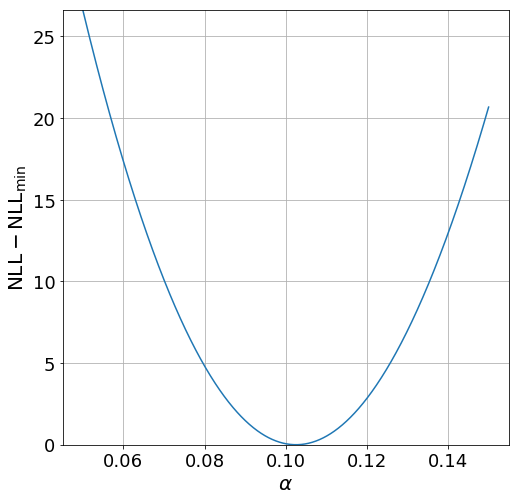

In [36]:
# scan the objective
xx = np.linspace(0.05, 0.15, 1000)
dx = (xx[1:] - xx[:-1])
nll_scan   = np.array([objective_nll([p], templates, digi_data) for p in xx]) - result.fun
dnll_scan  = (nll_scan[1:] - nll_scan[:-1])/dx
d2nll_scan = (dnll_scan[1:] - dnll_scan[:-1])/dx[:-1]
sig = np.sqrt(1/d2nll_scan[np.argmin(nll_scan)])

plt.figure(figsize=(8, 8), facecolor='white')
plt.plot(xx, nll_scan)
plt.grid()
plt.ylim(-5e-3, nll_scan.max())
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\sf NLL - NLL_{min}$')
plt.show()

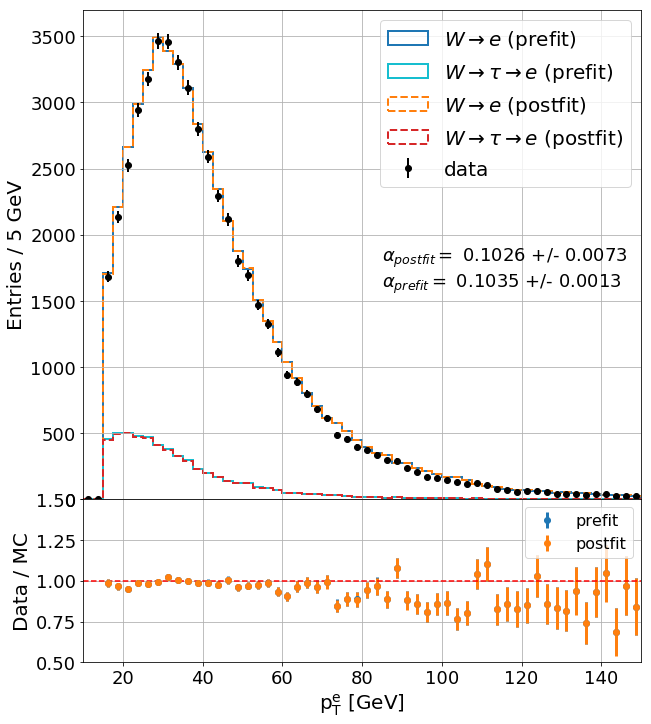

In [37]:
# make the plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})
fig.subplots_adjust(hspace=0)
x, y, yerr = pt.hist_to_errorbar(df_data['lepton2_pt'], hist_lut.n_bins, (hist_lut.xmin, hist_lut.xmax))
axes[0].errorbar(x, y, yerr,
                 fmt        = 'ko',
                 capsize    = 0,
                 elinewidth = 2
                )

hdata  = [df['lepton2_pt'].values for df in df_split]
h_pre, b, _ = axes[0].hist(hdata, 
                           bins=hist_lut.n_bins, 
                           range=(hist_lut.xmin, hist_lut.xmax), 
                           linewidth=2,
                           color=['C9', 'C0'], 
                           histtype='step', 
                           stacked=True, 
                           weights=[df['weight'] for df in df_split]
                          )

# calculate default mixture and error
num = h_pre[0].sum()
den = h_pre[-1].sum()
alpha0 = num/den
alpha0_err = [np.abs(alpha0 - beta.ppf(0.16, num, den - num + 1)), 
              np.abs(alpha0 - beta.ppf(0.84, num + 1, den - num))]
h_post, b, _ = axes[0].hist(hdata, 
                            bins=hist_lut.n_bins, 
                            range=(hist_lut.xmin, hist_lut.xmax), 
                            linewidth=2,
                            color=['C3', 'C1'], 
                            histtype='step', 
                            linestyle='dashed',
                            stacked=True, 
                            weights=[(result.x[0]/alpha0)*df_split[0]['weight'], (1 - result.x[0])/(1 - alpha0)*df_split[1]['weight']]
                           )
## calculate ratios
herr = np.sqrt(mc_hists['lepton2_pt'][0][1] + mc_hists['lepton2_pt'][1][1]) 
ratio_pre = y/h_pre[-1]
ratio_err = np.sqrt(y/h_pre[-1]**2 + (y*herr/h_pre[-1]**2)**2)
axes[1].errorbar(x, ratio_pre, ratio_err,
                 fmt        = 'C0o',
                 ecolor     = 'C0',
                 capsize    = 0,
                 elinewidth = 3,
                 alpha = 1.
                )

ratio_post = y/h_post[-1]
ratio_err = np.sqrt(y/h_post[-1]**2 + (y*herr/h_post[-1]**2)**2)
axes[1].errorbar(x, ratio_post, ratio_err,
                 fmt        = 'C1o',
                 ecolor     = 'C1',
                 capsize    = 0,
                 elinewidth = 3,
                 alpha = 1.
                )

axes[1].grid()
axes[1].set_xlabel(r'$\sf p_{T}^{e}$ [GeV]')
axes[1].set_ylabel('Data / MC')
axes[1].set_ylim(0.5, 1.5)
axes[1].legend(['prefit', 'postfit'], loc=1, fontsize=16)
axes[1].plot([hist_lut.xmin, hist_lut.xmax], [1, 1], 'r--')

axes[0].grid()
axes[0].set_ylabel(r'Entries / 5 GeV')
axes[0].set_xlim(10, 150)
axes[0].legend([r'$W\rightarrow e$ (prefit)', r'$W\rightarrow\tau\rightarrow e$ (prefit)', 
                r'$W\rightarrow e$ (postfit)', r'$W\rightarrow\tau\rightarrow e$ (postfit)', 'data'])

axes[0].text(85, 1800, r'$\alpha_{postfit} = $' + f' {result.x[0]:3.4} +/- {sig:2.2}', {'size':18})
axes[0].text(85, 1600, r'$\alpha_{prefit} = $' + f' {alpha0:3.4} +/- {np.mean(alpha0_err):2.2}', {'size':18})

plt.savefig('plots/fit_el_channel.png')
plt.show()